The example in paper is sample #683, dimension 13, first 15 seconds.

# Colab Setup

In [1]:
# set tensorflow version
%tensorflow_version 2.x
import tensorflow as tf
tf.__version__

'2.5.0'

In [2]:
# connect google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# copy the script file to current folder so it can be imported.
import shutil
import os
original = [
  r'/content/drive/My Drive/time_sequence_alchemy/utils/data_prep.py',
  r'/content/drive/My Drive/time_sequence_alchemy/utils/model.py',
  r'/content/drive/My Drive/time_sequence_alchemy/utils/others.py',
  r'/content/drive/My Drive/time_sequence_alchemy/utils/plot.py',
  r'/content/drive/My Drive/time_sequence_alchemy/log_embeddings_16_sg.txt',
]
target = [
  r'./utils/data_prep.py',
  r'./utils/model.py',
  r'./utils/others.py',
  r'./utils/plot.py',
  r'./log_embeddings_16_sg.txt',
]

if not os.path.exists('./utils'):
  os.makedirs('./utils')

for orig, targ in zip(original, target):
  shutil.copyfile(orig, targ)
  print('Script copied:', targ)


Script copied: ./utils/data_prep.py
Script copied: ./utils/model.py
Script copied: ./utils/others.py
Script copied: ./utils/plot.py
Script copied: ./log_embeddings_16_sg.txt


In [4]:
# data file on Colab
data_fn = r'/content/drive/My Drive/time_sequence_alchemy/data/HDFS/Xy_dataset.pkl'

In [5]:
from utils.data_prep import tokenize, trim_time_sequence, remove_long_sequence, pad_time_sequence
from utils.data_prep import prepare_dataset_v3, oversample_dataset
from utils.model import TimeChanger_FFT, TimeChangerLstm, TimeChanger, naive_evaluate, load_embeddings
from utils.model import ResampleLayer
from utils.others import print_train_info_v2, plot_and_save
from utils import plot
import tensorflow as tf
import numpy as np
import pickle
from time import time
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

# Load Data

In [8]:
TS_LIMIT = 120  # samples will be trimmed/picked within this limit (sec)
TS_TRIM = TS_LIMIT

# Load data
print('\nLoading data...', end='')
start = time()
with open(data_fn,'rb') as f:
  X, y = pickle.load(f)
print('{:.2f}s'.format(time()-start), end='\t')
print('{:d} samples'.format(len(y)))

# separate value & timestamp
print('\nProcessing data...', end='')
start = time()
x_seq =  X[:, 0]
x_ts = X[:, 1].copy()
# y = y[0:5000]
del X

# tokenization
x_tok, tokenizer = tokenize(x_seq)  # 48 tokens
vocab_size = len(tokenizer.word_counts)
# trim/remove data to a certain time length
x_tok, x_ts, y = remove_long_sequence(x_tok, x_ts, y, TS_LIMIT)  # remove sequence that are longer than limit
trim_time_sequence(x_tok, x_ts, TS_TRIM)  # trim sequence to limit
# front pad data to form matrices.
#x_tok, x_ts = pad_time_sequence(x_tok, x_ts, 
#    maxlen=250, ts_interval=0.1)

print('{:.2f}s'.format(time()-start), end='\t')
print('{:d} samples, {:d} samples with label=1.'.format(len(y), sum(y)))


Loading data...39.76s	575061 samples

Processing data...20.66s	101245 samples, 6422 samples with label=1.


In [9]:
x_tok_raw = x_tok
x_ts_raw = x_ts
x_tok, x_ts = pad_time_sequence(x_tok, x_ts, 
    maxlen=250, ts_interval=0.1)

## Load embeddings
Load the word2vec results. For token 0 (placeholder), set embedding to all 0.

In [10]:
embeddings, embedding_dims = load_embeddings('./log_embeddings_16_sg.txt')
# obtain token - embedding matrix, token zero's embedding is zero.
embedding_matrix = np.zeros((vocab_size+1, embedding_dims))

for word, i in tokenizer.word_index.items():
    embedding_matrix[i] = embeddings[word]

print(embedding_matrix.shape)

vocab_size, embedding_dims: 48 16
(49, 16)


# Load Models

I only saved checkpoint data, not the whole model, so have to create model first.

In [13]:
class TimeChangerCnn(tf.keras.Model):
  def __init__(self, vocab_size, embedding_matrix):
    super().__init__()
    
    embedding_dims = 16
    self.embed = tf.keras.layers.Embedding(
      vocab_size+1, embedding_dims,     # +1 because of padding 0
      embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
      trainable=False, input_length=250)  # input_length=input_length)
    max_duration = TS_TRIM # seconds
    resolution = 0.1   # seconds
    self.resample = ResampleLayer(max_duration, resolution)
    self.cnn_model = tf.keras.models.Sequential([
      # tf.keras.layers.Conv1D(filters=32, kernel_size=4, strides=1),
      tf.keras.layers.Conv1D(filters=32, kernel_size=8, strides=3),
      # tf.keras.layers.MaxPool1D(pool_size=2),
      # tf.keras.layers.Conv1D(filters=32, kernel_size=4, strides=1),
      tf.keras.layers.GlobalMaxPool1D(),
      #tf.keras.layers.MaxPool1D(pool_size=2),
      #tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(units=32, activation='relu'),
      # tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(units=32, activation='relu'),
      tf.keras.layers.Dense(units=1, activation='sigmoid'),
    ])
    
  #@tf.function
  def call(self, data):
    in_seq, ts_seq = data
    in_seq = self.embed(in_seq)
    output = self.resample((in_seq, ts_seq))
    output = self.cnn_model(output)
    return output

model = TimeChangerCnn(vocab_size, embedding_matrix)
model((x_tok[0:2], x_ts[0:2]))
model.summary()

Model: "time_changer_cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  784       
_________________________________________________________________
resample_layer (ResampleLaye multiple                  0         
_________________________________________________________________
sequential (Sequential)      (2, 1)                    6273      
Total params: 7,057
Trainable params: 6,273
Non-trainable params: 784
_________________________________________________________________


In [14]:
for i in range(1000):
  if len(x_tok_raw[i])>3:
    print(i, len(x_tok_raw[i]))

3 4
5 4
8 4
10 4
11 4
13 4
14 4
17 4
19 4
20 4
23 4
24 4
26 4
27 4
28 4
31 4
34 4
35 4
36 4
39 4
40 4
44 4
46 4
51 4
52 4
53 4
54 4
55 4
56 4
61 4
62 4
65 4
66 4
69 4
70 4
71 4
72 4
76 4
77 4
79 4
80 4
81 4
85 4
86 4
87 4
88 4
90 4
91 4
93 4
95 4
97 4
98 4
99 4
101 4
102 4
104 4
106 4
107 4
108 4
111 4
117 4
118 4
121 4
122 4
123 4
125 4
126 4
128 4
129 4
130 4
131 4
137 4
139 4
140 4
144 4
145 4
146 4
147 4
150 4
151 4
155 4
156 4
162 4
163 4
164 4
166 4
167 4
168 4
174 4
175 4
177 4
178 4
179 4
180 4
181 4
182 4
187 4
188 4
189 4
191 4
193 4
196 4
199 4
200 4
201 4
203 4
204 4
206 4
209 4
211 4
212 4
213 4
215 4
218 4
220 4
225 4
228 4
230 4
233 4
235 4
242 4
243 4
244 4
250 4
251 4
255 4
256 4
260 4
262 4
263 4
268 4
270 4
272 4
273 4
277 4
278 4
283 4
286 4
287 4
288 4
292 4
294 4
296 4
297 4
298 4
299 4
300 4
301 4
303 4
304 4
305 4
306 4
312 4
314 4
316 4
317 4
320 4
322 4
325 4
326 4
327 4
328 4
329 4
332 4
338 4
339 4
341 4
344 4
345 4
348 4
350 4
352 4
353 4
356 4
357 4
358 4


In [15]:
x_tok_raw[551]

[1, 1, 7, 16]

In [16]:
x_tok_raw[643]

[1, 7, 1, 1, 3, 4, 3, 4, 3, 4, 2, 2, 2, 6, 6, 6, 5, 5, 5]

In [17]:
i = 683# 683 good
# find the actual length of this sequence
for j in range(249, 0, -1):
  if x_tok[i,j] == 0: break
size = 249 - j
print("size of #{} sequence sample: {}".format(i, size))

# obtain the embeddings
emb = model.layers[0](x_tok[i:i+1])
emb = emb[0, j+1:, :].numpy()
emb.shape

# obtain the tokens and timestamps in seconds
tkn = x_tok[i, j+1:]
print("Token sequence:", tkn)
ts = x_ts[i, j+1:]
ts = ts - ts[0]
print("Timestamp sequence:", ts)

size of #683 sequence sample: 20
Token sequence: [ 1  1  1  7  3  4  3  4  3  4  2  2  2  6  6  6  5  5  5 15]
Timestamp sequence: [ 0.         0.25       0.5        0.75       3.         3.111
  3.2220001  3.3330002  3.4440002  3.5550003  3.6660004  3.7770004
  3.8880005 23.        23.333     23.666     25.        41.
 42.        44.       ]


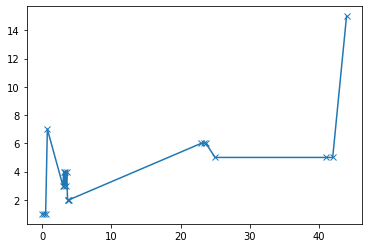

In [18]:
# plot token vs time (no meaning)
plt.plot(ts, tkn, 'x-')

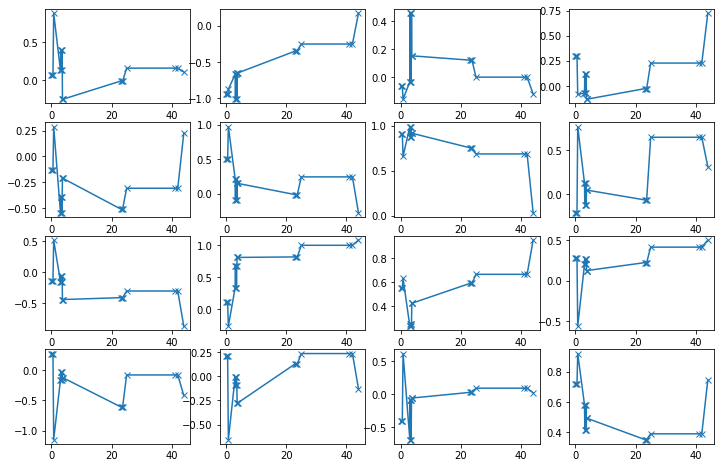

In [19]:
# plot embeddings vs time
plt.figure(figsize=[12,8])
for k in range(1,17):
  plt.subplot(4,4,k)
  plt.plot(ts, emb[:,k-1], 'x-')

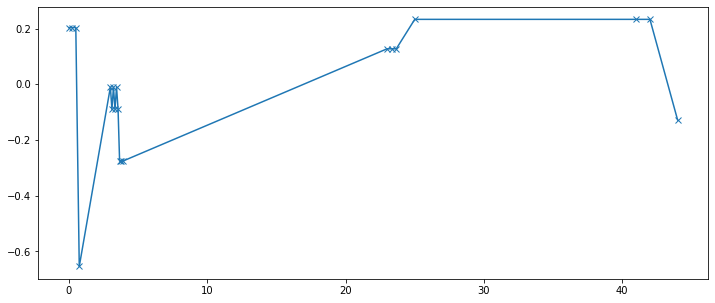

In [20]:
# pick one embedding dimension
emb_dim = 13   # #683-dim-13
t = ts
x = emb[:,emb_dim]
plt.figure(figsize=[12,5])
plt.plot(t, x, 'x-')

## Interpolation with x,y

In [21]:
TITLE_SIZE = 16
LABEL_SIZE = 16
TICK_SIZE = 14
LEGEND_SIZE = 16
FIGSIZE = (10,4.5)

In [22]:
# set a time limit so that it's not too long
tmax = 15  # seconds  

for q in range(len(t)):
  if t[q] > 20: break
t = t[0:q]
x = x[0:q]

(-0.75, 0.35)

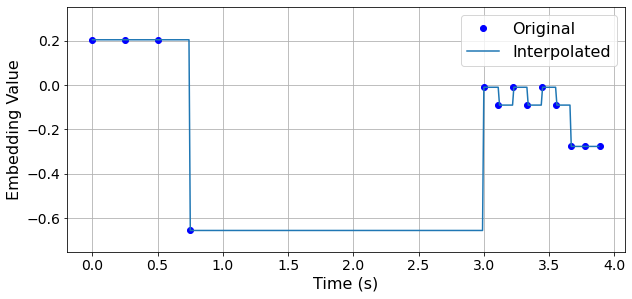

In [23]:
from scipy.interpolate import interp1d
f = interp1d(t, x, kind='previous')

ti = np.arange(0, t[-1]+0.01, 0.1) # not used
xi = f(ti)
tii = np.arange(0, t[-1]+0.001, 0.01)
xii = f(tii)

plt.figure(figsize=FIGSIZE)
#plt.plot(ti, xi, 'o', color='blue')
plt.plot(t,x, 'o',color='blue')
plt.plot(tii, xii, '-')
plt.xticks(fontsize=TICK_SIZE)
plt.yticks(fontsize=TICK_SIZE)
plt.grid()
plt.legend(['Original', 'Interpolated'], fontsize=LEGEND_SIZE)
plt.ylabel('Embedding Value', fontsize=LABEL_SIZE)
plt.xlabel('Time (s)', fontsize=LABEL_SIZE)
plt.ylim([-0.75,0.35])
# plt.xlim([0,tmax])

(-0.75, 0.35)

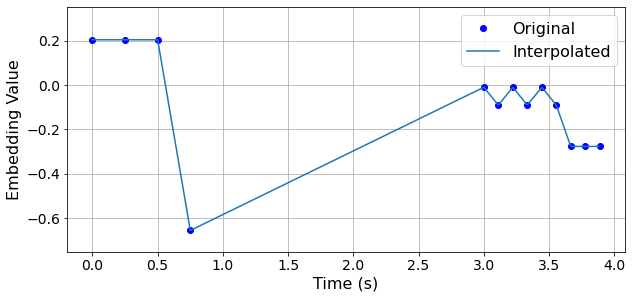

In [24]:
from scipy.interpolate import interp1d
f = interp1d(t, x)

ti = np.arange(0, t[-1]+0.01, 0.05)
xi = f(ti)
tii = np.arange(0, t[-1]+0.001, 0.01)
xii = f(tii)

plt.figure(figsize=FIGSIZE)
plt.plot(t,x, 'o', color='blue')
plt.plot(tii, xii, '-')
# plt.plot(ti, xi, 'o', color='blue')
plt.legend(['Original', 'Interpolated'], fontsize=LEGEND_SIZE)
plt.ylabel('Embedding Value', fontsize=LABEL_SIZE)
plt.xlabel('Time (s)', fontsize=LABEL_SIZE)
plt.xticks(fontsize=TICK_SIZE)
plt.yticks(fontsize=TICK_SIZE)
plt.grid()
plt.ylim([-0.75,0.35])
# plt.xlim([0,tmax])

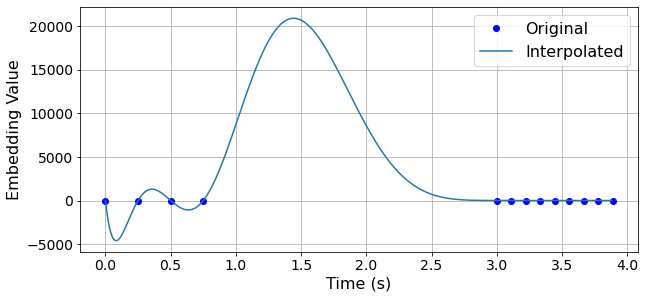

In [28]:
from scipy.interpolate import lagrange
poly = lagrange(t, x)
ti = np.arange(0, t[-1]+0.01, 0.1)
xi = poly(ti)

tii = np.arange(0, t[-1]+0.001, 0.01)
xii = poly(tii)

plt.figure(figsize=FIGSIZE)
plt.plot(t,x, 'o',color='blue')
#plt.plot(ti, xi, 'o-')
plt.plot(tii, xii, '-')
plt.legend(['Original', 'Interpolated'], fontsize=LEGEND_SIZE)
plt.ylabel('Embedding Value', fontsize=LABEL_SIZE)
plt.xlabel('Time (s)', fontsize=LABEL_SIZE)
plt.xticks(fontsize=TICK_SIZE)
plt.yticks(fontsize=TICK_SIZE)
plt.grid()
#plt.ylim([-2000,2000])

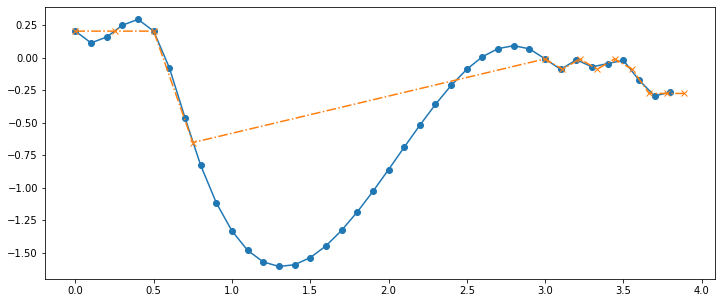

In [26]:
from scipy.interpolate import interp1d
f_lin = interp1d(t, x, kind='cubic')

ti = np.arange(0, t[-1]+0.01, 0.1)
xi = f_lin(ti)

plt.figure(figsize=[12,5])
plt.plot(ti, xi, 'o-')
plt.plot(t,x, 'x-.')
#plt.ylim([-0.5,1.1])

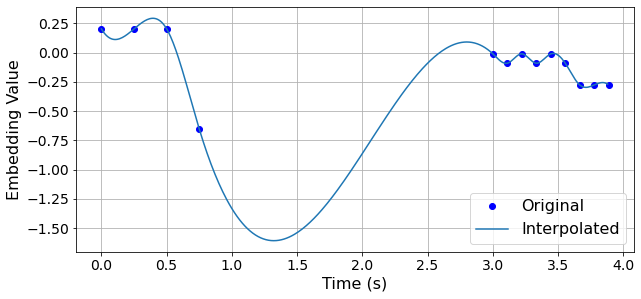

In [27]:
from scipy.interpolate import interp1d
f = interp1d(t, x, kind='cubic')

ti = np.arange(0, t[-1]+0.01, 0.05)
xi = f(ti)
tii = np.arange(0, t[-1]+0.001, 0.01)
xii = f(tii)

plt.figure(figsize=FIGSIZE)
plt.plot(t,x, 'o', color='blue')
plt.plot(tii, xii, '-')
# plt.plot(ti, xi, 'o', color='blue')
plt.legend(['Original', 'Interpolated'], fontsize=LEGEND_SIZE)
plt.ylabel('Embedding Value', fontsize=LABEL_SIZE)
plt.xlabel('Time (s)', fontsize=LABEL_SIZE)
plt.xticks(fontsize=TICK_SIZE)
plt.yticks(fontsize=TICK_SIZE)
plt.grid()
# plt.ylim([-0.75,0.35])
# plt.xlim([0,tmax])